In [1]:
using Plots, Random, LinearAlgebra, Statistics
pyplot()

Plots.PyPlotBackend()

In [2]:
"""plot line y = w*x+b"""
function plotline(w,b;
                  xmin=-100,xmax=100,label="")
    xsamples = [xmin, xmax]
    plot!(xsamples, [w*x+b for x in xsamples], color=:black, label=label)
end

plotline

In [3]:
"""plot function y=f(x)"""
function plotfunc(f;
                  xmin=-100,xmax=100,nsamples=100,label="")
    xsamples = LinRange(xmin,xmax,nsamples)
    plot!(xsamples, [f(x) for x in xsamples], color=:black, label=label)
end

plotfunc

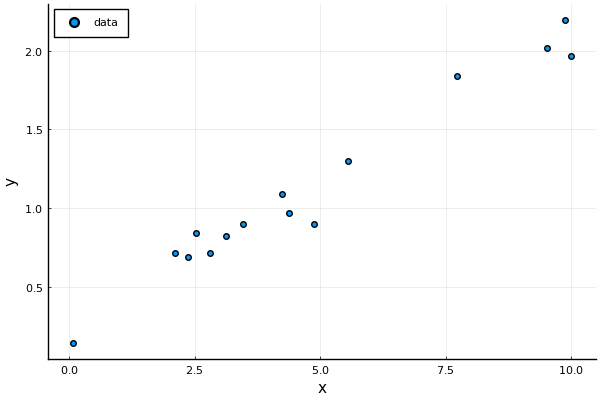

In [4]:
# Generate and plot data
Random.seed!(1)
n = 15
function sample_data(num_points)
    x = rand(num_points)*10
    y = .2 .+ .2*x + .1*sin.(x) + .1*randn(num_points) - .01*((x.-5)/6).^4
    return x,y
end
x,y = sample_data(n)

"""function to plot the above data"""
function plotdata(x=x,y=y; margin=.05)
    scatter(x,y, label="data", legend=:topleft)
    xlabel!("x")
    ylabel!("y")
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
    xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
end
plotdata()

# Approximating with the mean

In [5]:
# the mean solves a very simple least squares problem:
X = ones(n,1)
w = X\y

1-element Array{Float64,1}:
 1.1418154306154014

In [6]:
# check the solution to our least squares problem is the mean
abs(mean(y) - w[1])

0.0

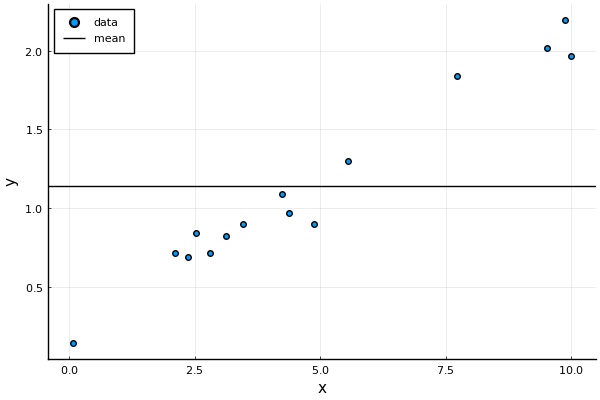

In [7]:
# plot the fit
plotdata()
plotline(0, w[1], label="mean")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Approximating with a line

In [8]:
X = [copy(x) ones(length(x))]

15×2 Array{Float64,2}:
 2.36033    1.0
 3.46517    1.0
 3.12707    1.0
 0.0790928  1.0
 4.88613    1.0
 2.10968    1.0
 9.51916    1.0
 9.99905    1.0
 2.51662    1.0
 9.86666    1.0
 5.55751    1.0
 4.37108    1.0
 4.24718    1.0
 7.73223    1.0
 2.8119     1.0

In [9]:
w = X\y

2-element Array{Float64,1}:
 0.1889327554101744
 0.22676530293763508

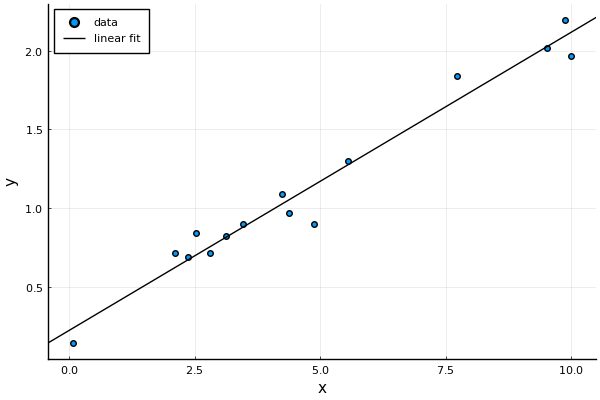

In [10]:
# plot the fit
plotdata()
plotline(w[1], w[2], label="linear fit")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

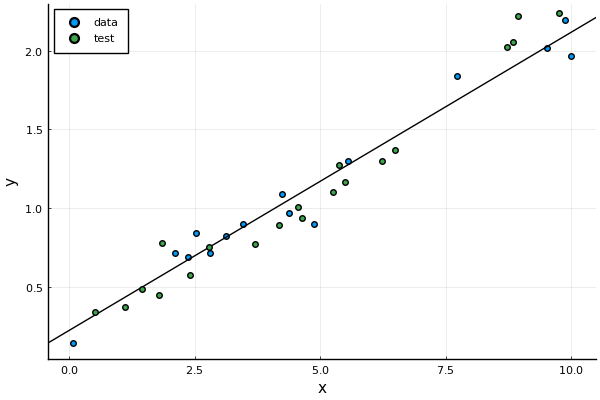

In [11]:
# plot fit on out of sample data
plotdata()
plotline(w[1], w[2])

xtest,ytest = sample_data(20)
scatter!(xtest,ytest,label="test")

# Approximating with a polynomial

In [12]:
# first, construct a Vandermonde matrix
max_order = 10

X = zeros(n, max_order+1)
for k=0:max_order
    X[:,k+1] = x.^k
end
X

15×11 Array{Float64,2}:
 1.0  2.36033     5.57117     …   2273.84          5367.03
 1.0  3.46517    12.0074         72031.3              2.49601e5
 1.0  3.12707     9.77856        28591.6          89407.8
 1.0  0.0790928   0.00625568         1.21125e-10      9.58013e-12
 1.0  4.88613    23.8742             1.58739e6        7.75619e6
 1.0  2.10968     4.45076     …    827.853         1746.51
 1.0  9.51916    90.6145             6.41784e8        6.10925e9
 1.0  9.99905    99.9809             9.99142e8        9.99047e9
 1.0  2.51662     6.33339         4049.13         10190.1
 1.0  9.86666    97.3511             8.86202e8        8.74386e9
 1.0  5.55751    30.8859      …      5.05735e6        2.81063e7
 1.0  4.37108    19.1063             5.82504e5        2.54617e6
 1.0  4.24718    18.0385             4.49681e5        1.90988e6
 1.0  7.73223    59.7874             9.87969e7        7.6392e8
 1.0  2.8119      7.90679        10990.1          30903.1

In [13]:
# solve least squares problem
w = X\y

11-element Array{Float64,1}:
    7.749005779363383
 -111.46843897473215
  207.77577819688415
 -173.2393058445392
   81.69821339093257
  -23.829430113722438
    4.450561445101657
   -0.5325582739395919
    0.03943967558058117
   -0.0016441581001478097
    2.9474334226661165e-5

In [14]:
"""computes our polynomial fit evaluated at x"""
function p(x; order = max_order, w = w)
    y = 0
    for k=0:order
        y += w[k+1]*x^k
    end
    return y
end

p

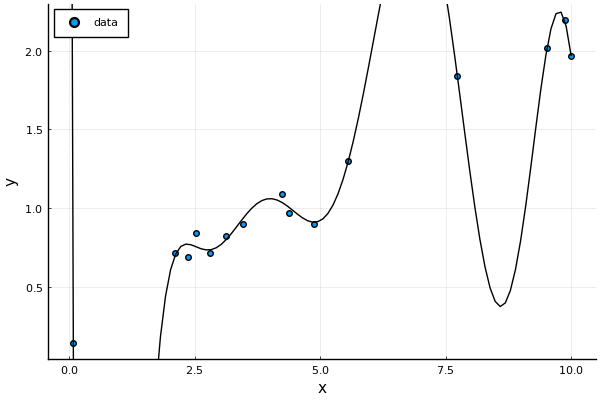

In [15]:
# plot fit
plotdata()
plotfunc(x -> p(x, order=max_order, w=w), xmin=0, xmax=10)

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

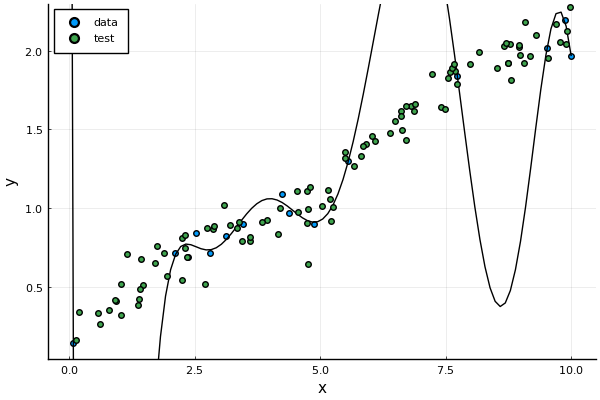

In [16]:
# plot fit on out of sample data
plotdata()
plotfunc(x -> p(x, order=max_order, w=w), xmin=0, xmax=10)

xtest,ytest = sample_data(100)
scatter!(xtest,ytest,label="test")

# Choosing the best model order

In [17]:
max_model_order = 10
rmse = zeros(max_model_order+1)       # array to store root mean square model errors
rmse_train = zeros(max_model_order+1) # array to store root mean square model errors on training set
xtest,ytest = sample_data(50)   # generate test set

for model_order = 0:max_model_order
    # form Vandermonde matrix
    X = zeros(n, model_order+1)
    for k=0:model_order
        X[:,k+1] = x.^k
    end
    
    # solve least squares problem
    w = X\y
    
    # compute training error 
    rmse_train[model_order+1] = mean(abs.(y - X*w)) # sqrt(mean((y - X*w).^2))
    
    # compute test error
    ptest = [p(x, order=model_order, w=w) for x in xtest]
    rmse[model_order+1] = mean(abs.(ytest - ptest)) # sqrt(mean((ytest - ptest).^2))
end
rmse

11-element Array{Float64,1}:
 0.5817645210364986
 0.09242932523978176
 0.09399286428569084
 0.09519064954953363
 0.08620810214521434
 0.08671865132967391
 0.08329866346820086
 0.08840831299136517
 0.41432227067293126
 0.28817179284319033
 1.2794529975637217

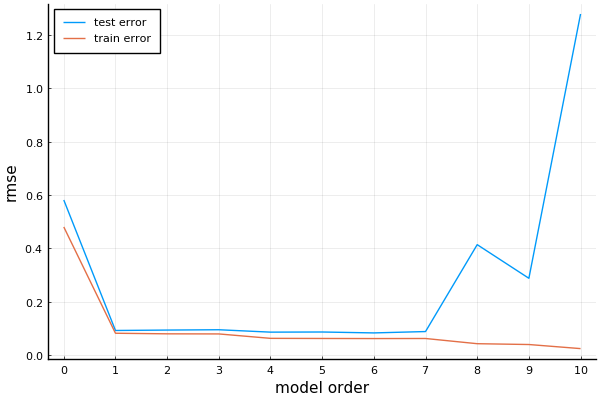

In [18]:
plot(0:max_model_order,rmse, label="test error")
plot!(0:max_model_order,rmse_train, label="train error")
xticks!(0:10)
xlabel!("model order")
ylabel!("rmse")

# Polynomial models for classification

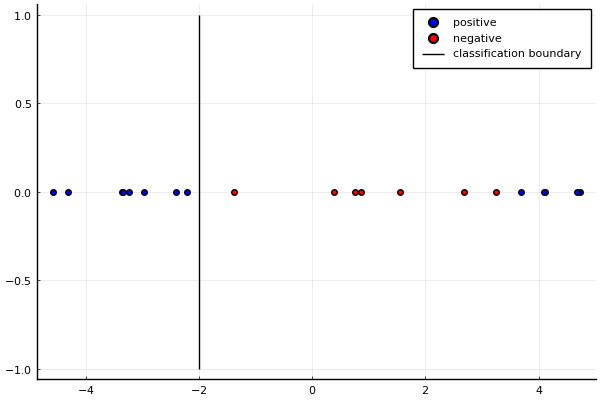

In [19]:
Random.seed!(0)
n = 20
xs = 10*(rand(n) .- .5)
ys = (xs).^2
pos = (xs .- 1).^2 .>= 7
zn=zeros(n)
pt = scatter(xs[pos],zn[pos],color="blue", label="positive")
scatter!(xs[.!pos],zn[.!pos],color="red", label="negative")
plot!([-2,-2], [-1,1], color="black", label="classification boundary")#, ticks=:none, border=:none, legend=false)
yaxis!([-1,1])
# savefig("poly-class-1d.pdf")
pt

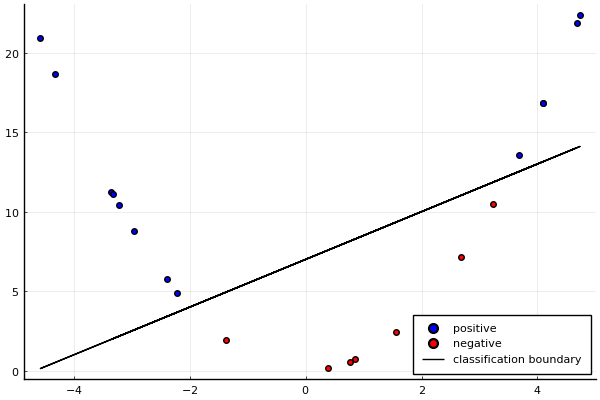

In [20]:
pt = scatter(xs[pos],ys[pos],color="blue", label="positive")
scatter!(xs[.!pos],ys[.!pos],color="red", label="negative")
plot!(xs, 1.5*xs .+ 7, color="black", label="classification boundary")
# savefig("poly-class-2d.pdf")
pt

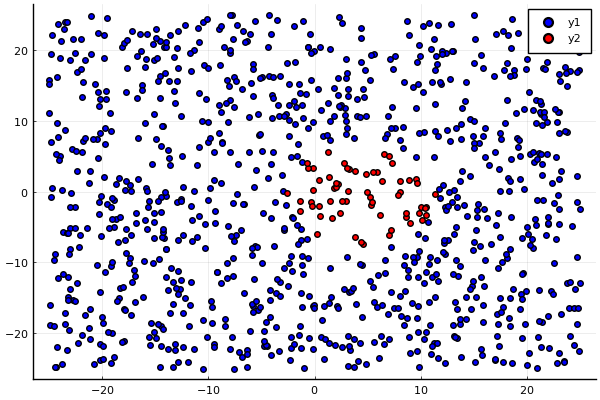

In [21]:
# Example 1: multivariate polynomial classification 
n = 1000
scale = 50
x1 = scale*rand(n) .- scale/2
x2 = scale*rand(n) .- scale/2
f(x1,x2) = -30 - 9x1 + 2x2 + x1^2 - 0x1*x2 + x2^2
y = f.(x1,x2)
pos = y.>0
neg = y.<0

scatter(x1[pos], x2[pos], color="blue")
scatter!(x1[neg], x2[neg], color="red",legend=:topright)

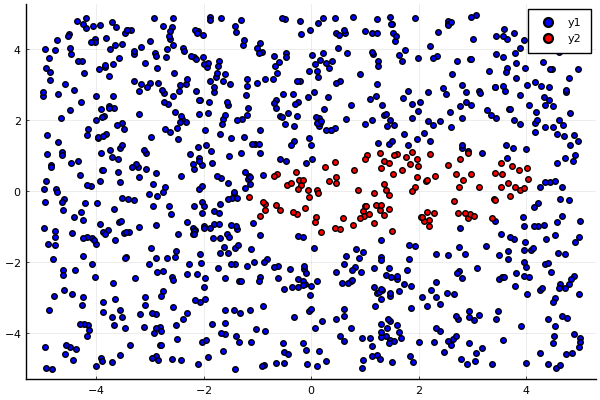

In [22]:
# Example 2: multivariate polynomial classification 
n = 1000
scale = 10
x1 = scale*rand(n) .- scale/2
x2 = scale*rand(n) .- scale/2
f(x1,x2) = -5 - 3x1 + 2x2 + x1^2 - x1*x2 + 5x2^2
y = f.(x1,x2)
pos = y.>0
neg = y.<0

scatter(x1[pos], x2[pos], color="blue")
scatter!(x1[neg], x2[neg], color="red",legend=:topright)

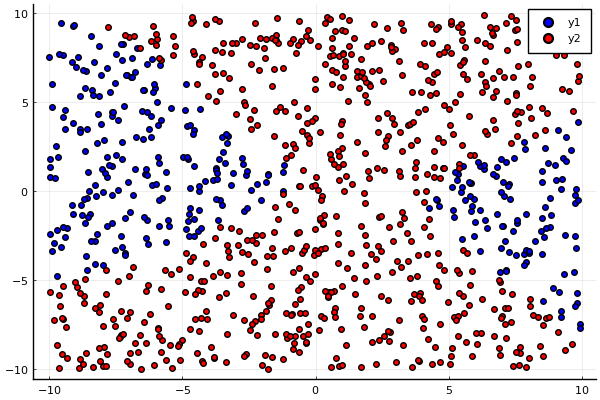

In [23]:
# Example 3: multivariate polynomial classification 
n = 1000
scale = 20
x1 = scale*rand(n) .- scale/2
x2 = scale*rand(n) .- scale/2
f(x1,x2) = -5 - 3x1 + 2x2 + x1^2 - x1*x2 - 2x2^2
y = f.(x1,x2)
pos = y.>0
neg = y.<0

scatter(x1[pos], x2[pos], color="blue")
scatter!(x1[neg], x2[neg], color="red",legend=:topright)

# Bootstrap estimators

In [79]:
# sample K data sets of n samples each and compute a model on each
# see how the models vary
n = 50
K = 1000

models = zeros(K,2)
for k=1:K
    xk,yk = sample_data(n) # this experiment samples from the true data distribution many many times (not usually implementable for real problems)
    Xk = [xk ones(n)]
    wk = Xk \ yk
    models[k,:] = wk
end

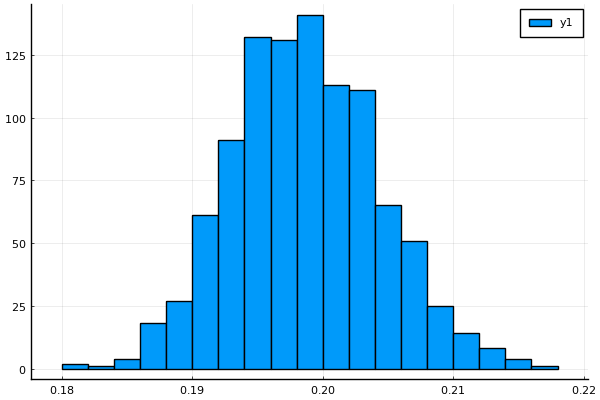

In [80]:
# histogram of the distribution of the first coefficient
# could use to compute, eg, confidence intervals

histogram(models[:,1])

In [49]:
mean(models, dims=1)

1×2 Array{Float64,2}:
 0.198168  0.226243

In [50]:
var(models,dims=1)

1×2 Array{Float64,2}:
 7.20133e-6  0.000240887

In [52]:
# can sample with replacement using rand
rand(1:20, 5)

5-element Array{Int64,1}:
  6
 15
 16
  6
 15

when I sample with replacement from 1:n, the values I produce are
1. A) Always distinct
2. B) Might not be distinct

In [29]:
# eg,
a = .1:.1:2.0
s = rand(1:20, 5)
[s a[s]]

5×2 Array{Float64,2}:
 15.0  1.5
  4.0  0.4
 18.0  1.8
 10.0  1.0
 18.0  1.8

when I sample n values with replacement from 1:n, 
1. A) I always get the same set of values as an answer (a permutation of 1:n)
2. B) there are many different sets of values I might see

In [58]:
rand(1:5, 5)

5-element Array{Int64,1}:
 5
 5
 2
 3
 1

In [87]:
# resample K bootstrap data sets of n samples each and compute a model on each
# see how the models vary
# how does result depend on number of datapoints n? number of resamples K?
n = 50
K = 1000

x,y = sample_data(n) # this is the only data we've got!

models = zeros(K,2)
for k=1:K
    mysample = rand(1:n,n)
    xk,yk = x[mysample], y[mysample]
    Xk = [xk ones(n)]
    wk = Xk \ yk
    models[k,:] = wk
end

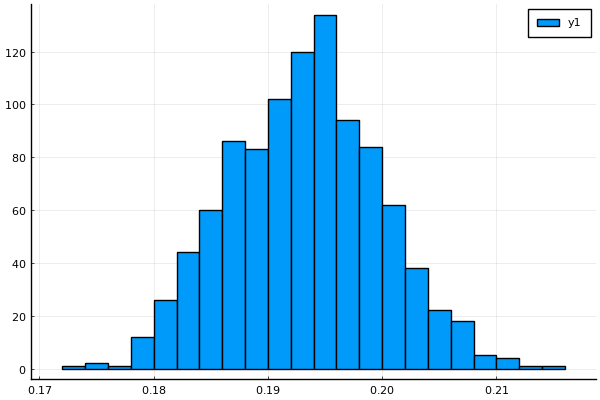

In [88]:
histogram(models[:,1])

In [90]:
mean(models,dims=1)

1×2 Array{Float64,2}:
 0.193223  0.256591

In [91]:
# as K increases, mean of the bootstrap models should converge to 
# the model fit on the original data set
X = [x ones(n)]
w = X \ y

2-element Array{Float64,1}:
 0.19317872815886772
 0.25659535402951333

In [73]:
var(models,dims=1)

1×2 Array{Float64,2}:
 3.00999e-5  0.00146304

In [99]:
Dict(zip(rand(1:n,5),1:5))

Dict{Int64,Int64} with 5 entries:
  35 => 4
  16 => 3
  17 => 2
  5  => 5
  18 => 1